In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU, BatchNormalization, LeakyReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [4]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [5]:
runs = [304125,304508,302263]

with open('normedRateAvg_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
with open('normedRateAvg_bad.pickle', 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

x_bad1 = np.array(bad_data['301480']['samples'])
x_bad2 = np.array(bad_data['305588']['samples'])



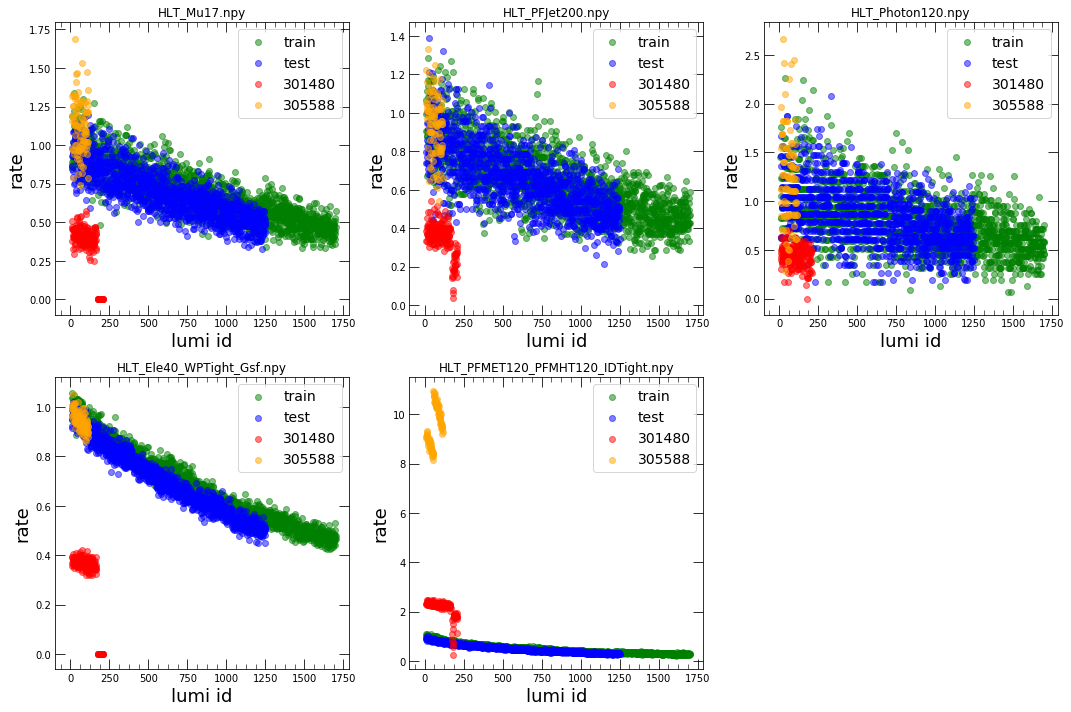

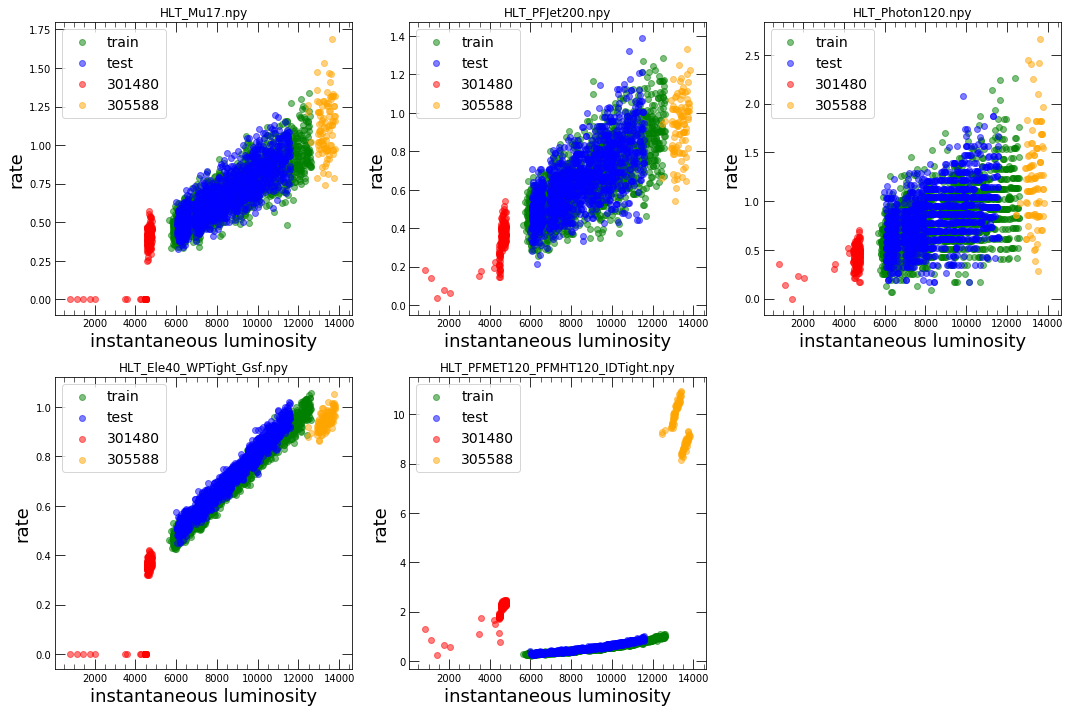

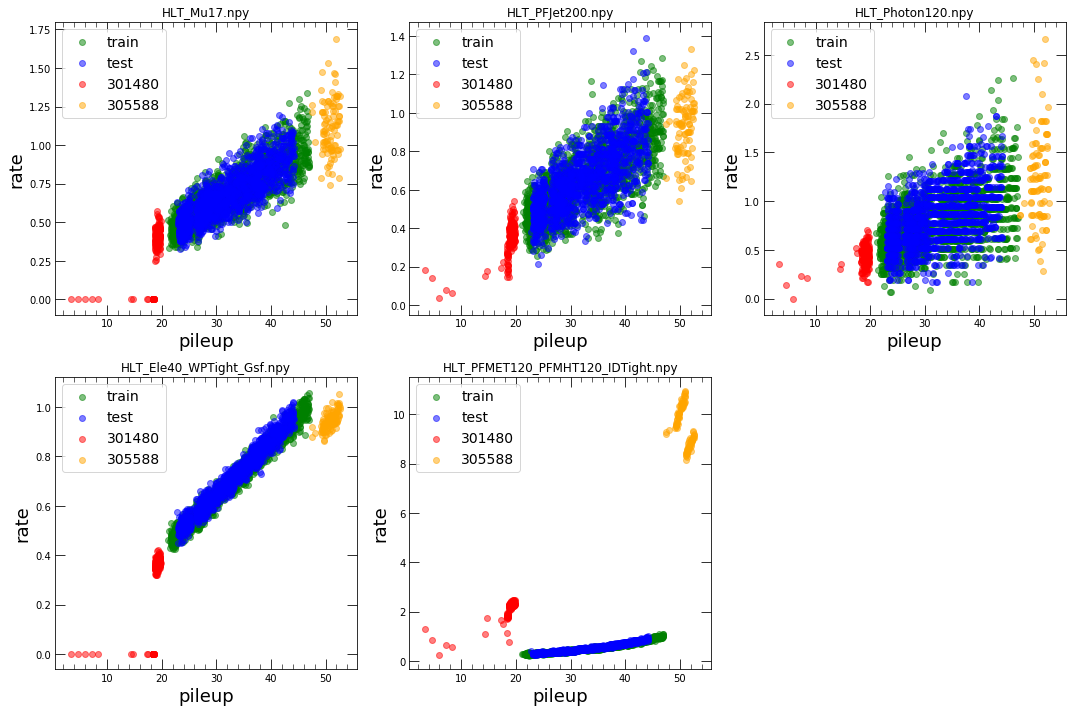

In [6]:
plots = [x_train,x_test,x_bad1,x_bad2]
titles = ["train","test","301480","305588"]

stuff = [[],[],[],[]]
lumi = [[],[],[],[]]
inst = [[],[],[],[]]
pileup = [[],[],[],[]]
for h in range(4):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    elif h == 2:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    else:
        lumi[h] = bad_data["305588"]['lumiid']
        inst[h] = bad_data["305588"]['instlumi']
        pileup[h] = bad_data["305588"]['pileup']
        stuff[h] = bad_data["305588"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r","orange"]
    
plt.figure(figsize=[15,10])
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Simple Autoencoder

In [7]:
model_name = "normedRateAvgRelu"

In [8]:
# Define the architecture

_input = Input(shape=(6,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="encoded")(_input)

output = Dense(6,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 21        
_________________________________________________________________
reconstructed (Dense)        (None, 6)                 24        
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


Train on 1669 samples, validate on 1224 samples
Epoch 1/1000
 - 1s - loss: 20.3095 - val_loss: 20.6669
Epoch 2/1000
 - 0s - loss: 19.8412 - val_loss: 20.1619
Epoch 3/1000
 - 0s - loss: 19.3537 - val_loss: 19.6515
Epoch 4/1000
 - 0s - loss: 18.8653 - val_loss: 19.1515
Epoch 5/1000
 - 0s - loss: 18.3845 - val_loss: 18.6638
Epoch 6/1000
 - 0s - loss: 17.9180 - val_loss: 18.1858
Epoch 7/1000
 - 0s - loss: 17.4582 - val_loss: 17.7179
Epoch 8/1000
 - 0s - loss: 17.0096 - val_loss: 17.2606
Epoch 9/1000
 - 0s - loss: 16.5695 - val_loss: 16.8143
Epoch 10/1000
 - 0s - loss: 16.1405 - val_loss: 16.3811
Epoch 11/1000
 - 0s - loss: 15.7244 - val_loss: 15.9541
Epoch 12/1000
 - 0s - loss: 15.3151 - val_loss: 15.5380
Epoch 13/1000
 - 0s - loss: 14.9150 - val_loss: 15.1353
Epoch 14/1000
 - 0s - loss: 14.5285 - val_loss: 14.7455
Epoch 15/1000
 - 0s - loss: 14.1526 - val_loss: 14.3640
Epoch 16/1000
 - 0s - loss: 13.7875 - val_loss: 13.9904
Epoch 17/1000
 - 0s - loss: 13.4303 - val_loss: 13.6312
Epoch 18/

Epoch 151/1000
 - 0s - loss: 0.8976 - val_loss: 0.9183
Epoch 152/1000
 - 0s - loss: 0.8840 - val_loss: 0.9045
Epoch 153/1000
 - 0s - loss: 0.8707 - val_loss: 0.8908
Epoch 154/1000
 - 0s - loss: 0.8576 - val_loss: 0.8775
Epoch 155/1000
 - 0s - loss: 0.8448 - val_loss: 0.8643
Epoch 156/1000
 - 0s - loss: 0.8322 - val_loss: 0.8514
Epoch 157/1000
 - 0s - loss: 0.8198 - val_loss: 0.8388
Epoch 158/1000
 - 0s - loss: 0.8076 - val_loss: 0.8264
Epoch 159/1000
 - 0s - loss: 0.7957 - val_loss: 0.8142
Epoch 160/1000
 - 0s - loss: 0.7840 - val_loss: 0.8023
Epoch 161/1000
 - 0s - loss: 0.7725 - val_loss: 0.7905
Epoch 162/1000
 - 0s - loss: 0.7612 - val_loss: 0.7790
Epoch 163/1000
 - 0s - loss: 0.7502 - val_loss: 0.7677
Epoch 164/1000
 - 0s - loss: 0.7392 - val_loss: 0.7566
Epoch 165/1000
 - 0s - loss: 0.7285 - val_loss: 0.7456
Epoch 166/1000
 - 0s - loss: 0.7180 - val_loss: 0.7349
Epoch 167/1000
 - 0s - loss: 0.7077 - val_loss: 0.7244
Epoch 168/1000
 - 0s - loss: 0.6975 - val_loss: 0.7140
Epoch 169/

Epoch 300/1000
 - 0s - loss: 0.1482 - val_loss: 0.1518
Epoch 301/1000
 - 0s - loss: 0.1468 - val_loss: 0.1504
Epoch 302/1000
 - 0s - loss: 0.1454 - val_loss: 0.1489
Epoch 303/1000
 - 0s - loss: 0.1441 - val_loss: 0.1475
Epoch 304/1000
 - 0s - loss: 0.1427 - val_loss: 0.1461
Epoch 305/1000
 - 0s - loss: 0.1414 - val_loss: 0.1448
Epoch 306/1000
 - 0s - loss: 0.1401 - val_loss: 0.1434
Epoch 307/1000
 - 0s - loss: 0.1388 - val_loss: 0.1421
Epoch 308/1000
 - 0s - loss: 0.1375 - val_loss: 0.1407
Epoch 309/1000
 - 0s - loss: 0.1362 - val_loss: 0.1394
Epoch 310/1000
 - 0s - loss: 0.1349 - val_loss: 0.1382
Epoch 311/1000
 - 0s - loss: 0.1337 - val_loss: 0.1369
Epoch 312/1000
 - 0s - loss: 0.1325 - val_loss: 0.1356
Epoch 313/1000
 - 0s - loss: 0.1313 - val_loss: 0.1344
Epoch 314/1000
 - 0s - loss: 0.1301 - val_loss: 0.1331
Epoch 315/1000
 - 0s - loss: 0.1289 - val_loss: 0.1319
Epoch 316/1000
 - 0s - loss: 0.1277 - val_loss: 0.1307
Epoch 317/1000
 - 0s - loss: 0.1266 - val_loss: 0.1295
Epoch 318/

Epoch 449/1000
 - 0s - loss: 0.0458 - val_loss: 0.0466
Epoch 450/1000
 - 0s - loss: 0.0455 - val_loss: 0.0463
Epoch 451/1000
 - 0s - loss: 0.0452 - val_loss: 0.0460
Epoch 452/1000
 - 0s - loss: 0.0449 - val_loss: 0.0457
Epoch 453/1000
 - 0s - loss: 0.0446 - val_loss: 0.0454
Epoch 454/1000
 - 0s - loss: 0.0443 - val_loss: 0.0451
Epoch 455/1000
 - 0s - loss: 0.0440 - val_loss: 0.0448
Epoch 456/1000
 - 0s - loss: 0.0437 - val_loss: 0.0445
Epoch 457/1000
 - 0s - loss: 0.0434 - val_loss: 0.0442
Epoch 458/1000
 - 0s - loss: 0.0431 - val_loss: 0.0439
Epoch 459/1000
 - 0s - loss: 0.0429 - val_loss: 0.0436
Epoch 460/1000
 - 0s - loss: 0.0426 - val_loss: 0.0433
Epoch 461/1000
 - 0s - loss: 0.0423 - val_loss: 0.0431
Epoch 462/1000
 - 0s - loss: 0.0420 - val_loss: 0.0428
Epoch 463/1000
 - 0s - loss: 0.0417 - val_loss: 0.0425
Epoch 464/1000
 - 0s - loss: 0.0415 - val_loss: 0.0422
Epoch 465/1000
 - 0s - loss: 0.0412 - val_loss: 0.0419
Epoch 466/1000
 - 0s - loss: 0.0409 - val_loss: 0.0417
Epoch 467/

Epoch 598/1000
 - 0s - loss: 0.0183 - val_loss: 0.0185
Epoch 599/1000
 - 0s - loss: 0.0182 - val_loss: 0.0184
Epoch 600/1000
 - 0s - loss: 0.0181 - val_loss: 0.0183
Epoch 601/1000
 - 0s - loss: 0.0180 - val_loss: 0.0182
Epoch 602/1000
 - 0s - loss: 0.0179 - val_loss: 0.0181
Epoch 603/1000
 - 0s - loss: 0.0178 - val_loss: 0.0179
Epoch 604/1000
 - 0s - loss: 0.0177 - val_loss: 0.0178
Epoch 605/1000
 - 0s - loss: 0.0176 - val_loss: 0.0177
Epoch 606/1000
 - 0s - loss: 0.0175 - val_loss: 0.0176
Epoch 607/1000
 - 0s - loss: 0.0174 - val_loss: 0.0175
Epoch 608/1000
 - 0s - loss: 0.0173 - val_loss: 0.0174
Epoch 609/1000
 - 0s - loss: 0.0172 - val_loss: 0.0173
Epoch 610/1000
 - 0s - loss: 0.0171 - val_loss: 0.0172
Epoch 611/1000
 - 0s - loss: 0.0170 - val_loss: 0.0171
Epoch 612/1000
 - 0s - loss: 0.0169 - val_loss: 0.0170
Epoch 613/1000
 - 0s - loss: 0.0168 - val_loss: 0.0169
Epoch 614/1000
 - 0s - loss: 0.0167 - val_loss: 0.0168
Epoch 615/1000
 - 0s - loss: 0.0166 - val_loss: 0.0167
Epoch 616/

Epoch 747/1000
 - 0s - loss: 0.0082 - val_loss: 0.0080
Epoch 748/1000
 - 0s - loss: 0.0081 - val_loss: 0.0079
Epoch 749/1000
 - 0s - loss: 0.0081 - val_loss: 0.0079
Epoch 750/1000
 - 0s - loss: 0.0080 - val_loss: 0.0079
Epoch 751/1000
 - 0s - loss: 0.0080 - val_loss: 0.0078
Epoch 752/1000
 - 0s - loss: 0.0080 - val_loss: 0.0078
Epoch 753/1000
 - 0s - loss: 0.0079 - val_loss: 0.0077
Epoch 754/1000
 - 0s - loss: 0.0079 - val_loss: 0.0077
Epoch 755/1000
 - 0s - loss: 0.0078 - val_loss: 0.0077
Epoch 756/1000
 - 0s - loss: 0.0078 - val_loss: 0.0076
Epoch 757/1000
 - 0s - loss: 0.0078 - val_loss: 0.0076
Epoch 758/1000
 - 0s - loss: 0.0077 - val_loss: 0.0075
Epoch 759/1000
 - 0s - loss: 0.0077 - val_loss: 0.0075
Epoch 760/1000
 - 0s - loss: 0.0076 - val_loss: 0.0075
Epoch 761/1000
 - 0s - loss: 0.0076 - val_loss: 0.0074
Epoch 762/1000
 - 0s - loss: 0.0076 - val_loss: 0.0074
Epoch 763/1000
 - 0s - loss: 0.0075 - val_loss: 0.0073
Epoch 764/1000
 - 0s - loss: 0.0075 - val_loss: 0.0073
Epoch 765/

Epoch 896/1000
 - 0s - loss: 0.0042 - val_loss: 0.0039
Epoch 897/1000
 - 0s - loss: 0.0042 - val_loss: 0.0039
Epoch 898/1000
 - 0s - loss: 0.0042 - val_loss: 0.0039
Epoch 899/1000
 - 0s - loss: 0.0042 - val_loss: 0.0039
Epoch 900/1000
 - 0s - loss: 0.0041 - val_loss: 0.0038
Epoch 901/1000
 - 0s - loss: 0.0041 - val_loss: 0.0038
Epoch 902/1000
 - 0s - loss: 0.0041 - val_loss: 0.0038
Epoch 903/1000
 - 0s - loss: 0.0041 - val_loss: 0.0038
Epoch 904/1000
 - 0s - loss: 0.0041 - val_loss: 0.0038
Epoch 905/1000
 - 0s - loss: 0.0041 - val_loss: 0.0038
Epoch 906/1000
 - 0s - loss: 0.0041 - val_loss: 0.0038
Epoch 907/1000
 - 0s - loss: 0.0040 - val_loss: 0.0037
Epoch 908/1000
 - 0s - loss: 0.0040 - val_loss: 0.0037
Epoch 909/1000
 - 0s - loss: 0.0040 - val_loss: 0.0037
Epoch 910/1000
 - 0s - loss: 0.0040 - val_loss: 0.0037
Epoch 911/1000
 - 0s - loss: 0.0040 - val_loss: 0.0037
Epoch 912/1000
 - 0s - loss: 0.0040 - val_loss: 0.0037
Epoch 913/1000
 - 0s - loss: 0.0039 - val_loss: 0.0036
Epoch 914/

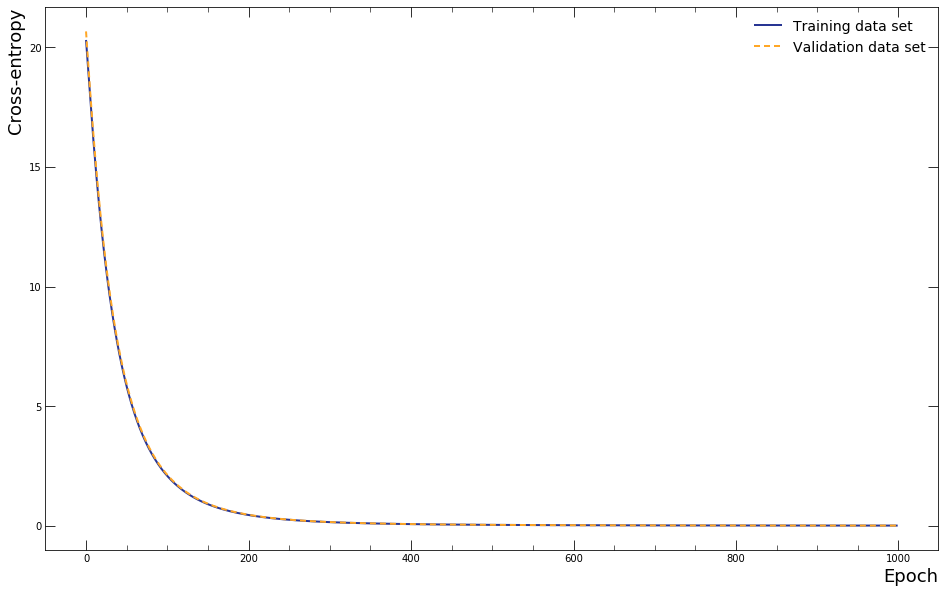

In [9]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

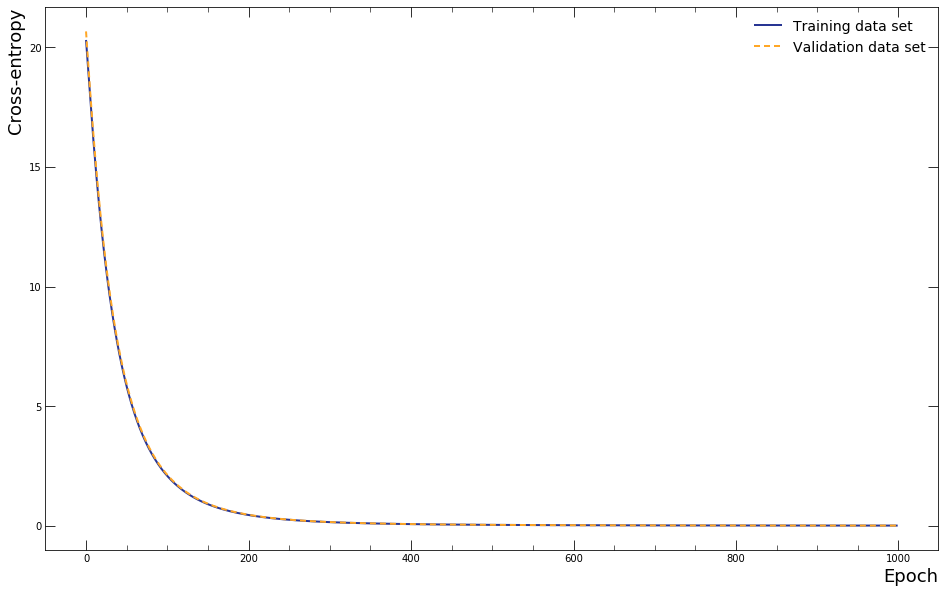

In [10]:
plot_loss(history)

## Training Set

In [11]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        lumi_new.append(lumi[l])
                
reconstructed = model.predict(np.array(x_train))

error = abs(x_train-reconstructed)/x_train

In [12]:
error_reformat = []
inp = []
outp = []
for i in range(6):
    error_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    for j in range(6):
        error_reformat[j].append(error[i][j])
        outp[j].append(reconstructed[i][j])
        inp[j].append(x_train_new[i][j])

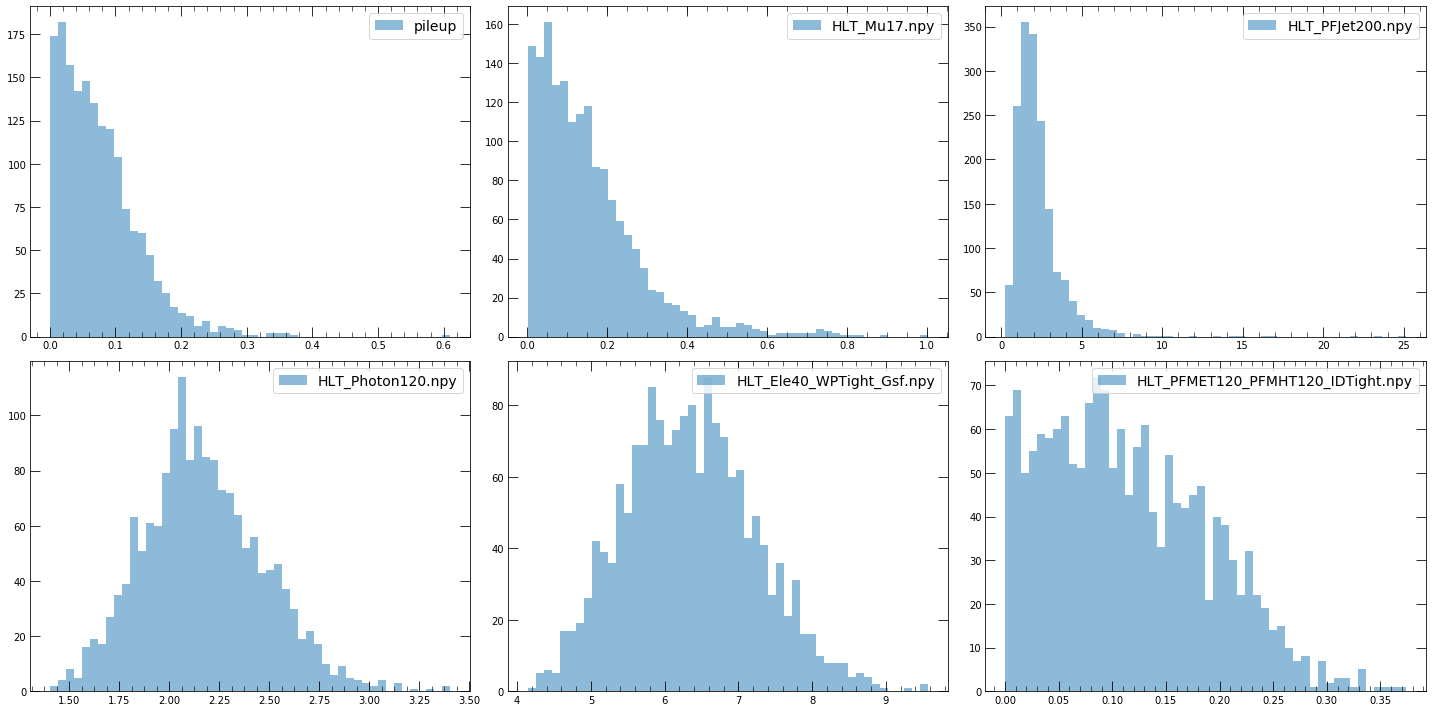

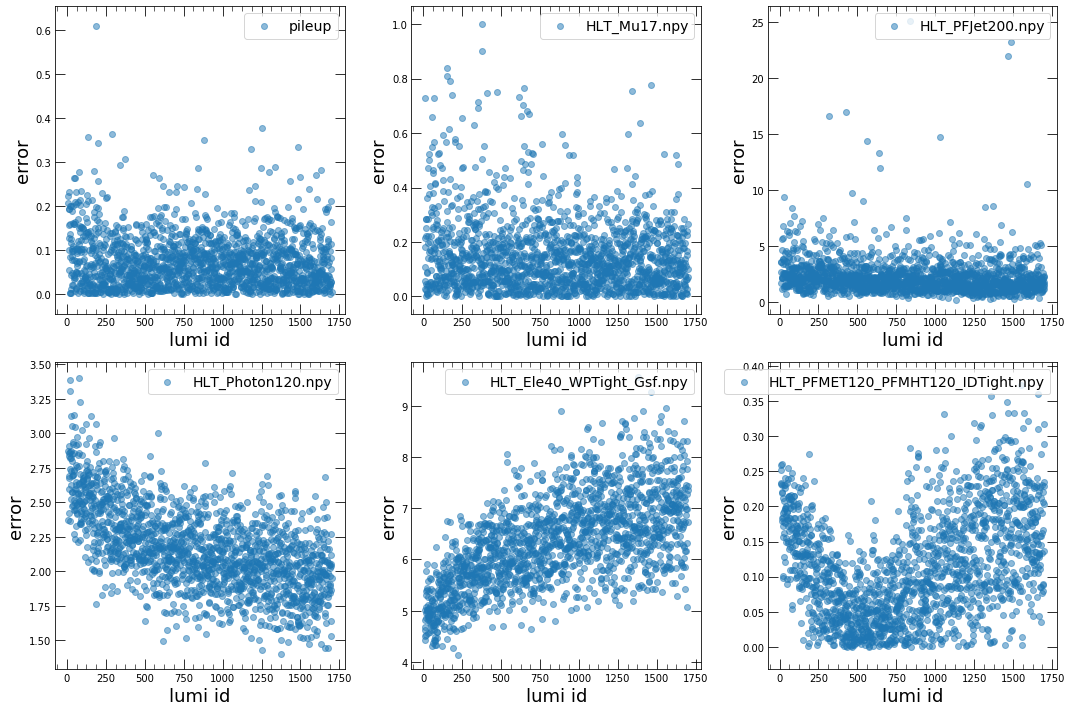

In [13]:
labels = ['pileup'] + data['HLT']
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
plt.tight_layout()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
plt.tight_layout()
plt.show()

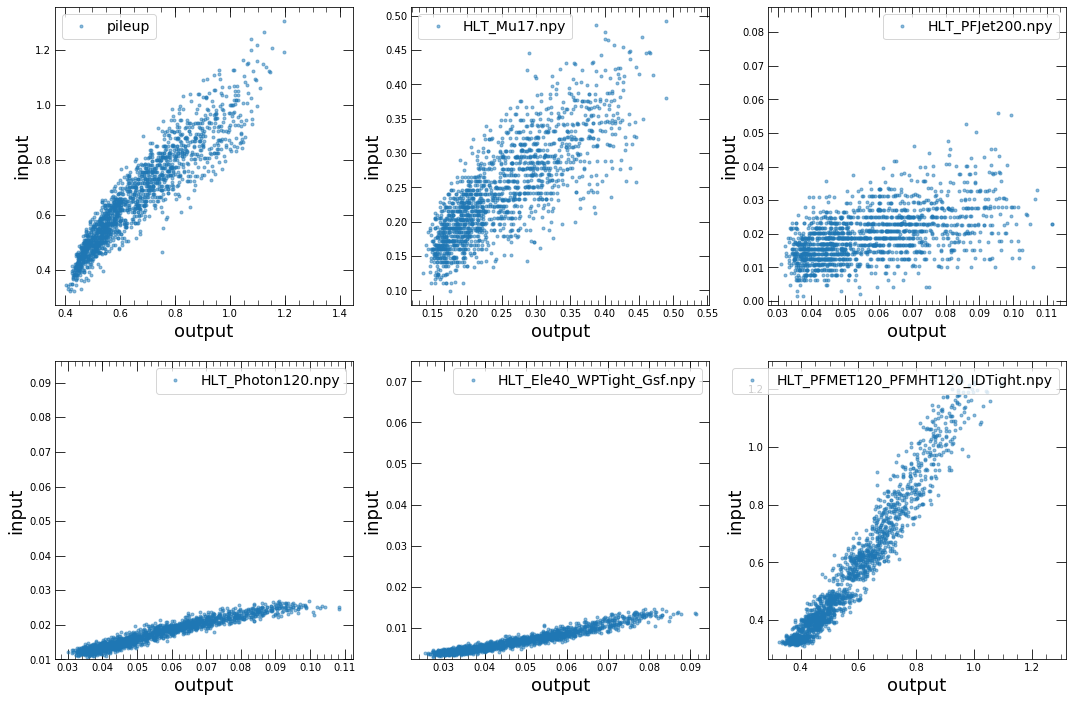

In [14]:
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend() 
    
    plt.axis('square')

plt.tight_layout()
plt.show()

## Test Data

In [15]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [16]:
error_reformat = []
inp = []
outp = []
for i in range(6):
    error_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    #print(len(error_reformat[0]))
    for j in range(6):
        error_reformat[j].append(error[i][j])
        outp[j].append(reconstructed[i][j])
        inp[j].append(x_test_new[i][j])

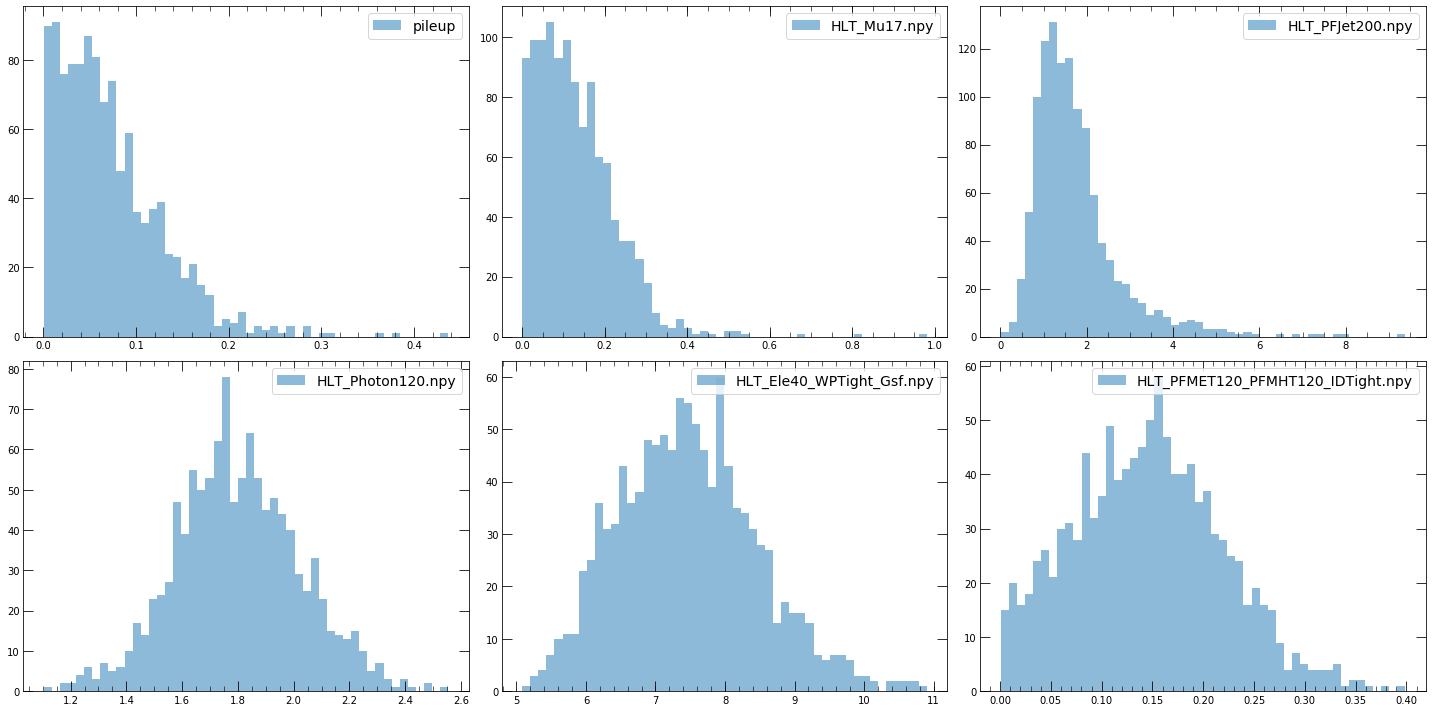

In [17]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.tight_layout()
plt.show()

In [18]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

In [21]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [22]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [19]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [20]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [21]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])
            
        

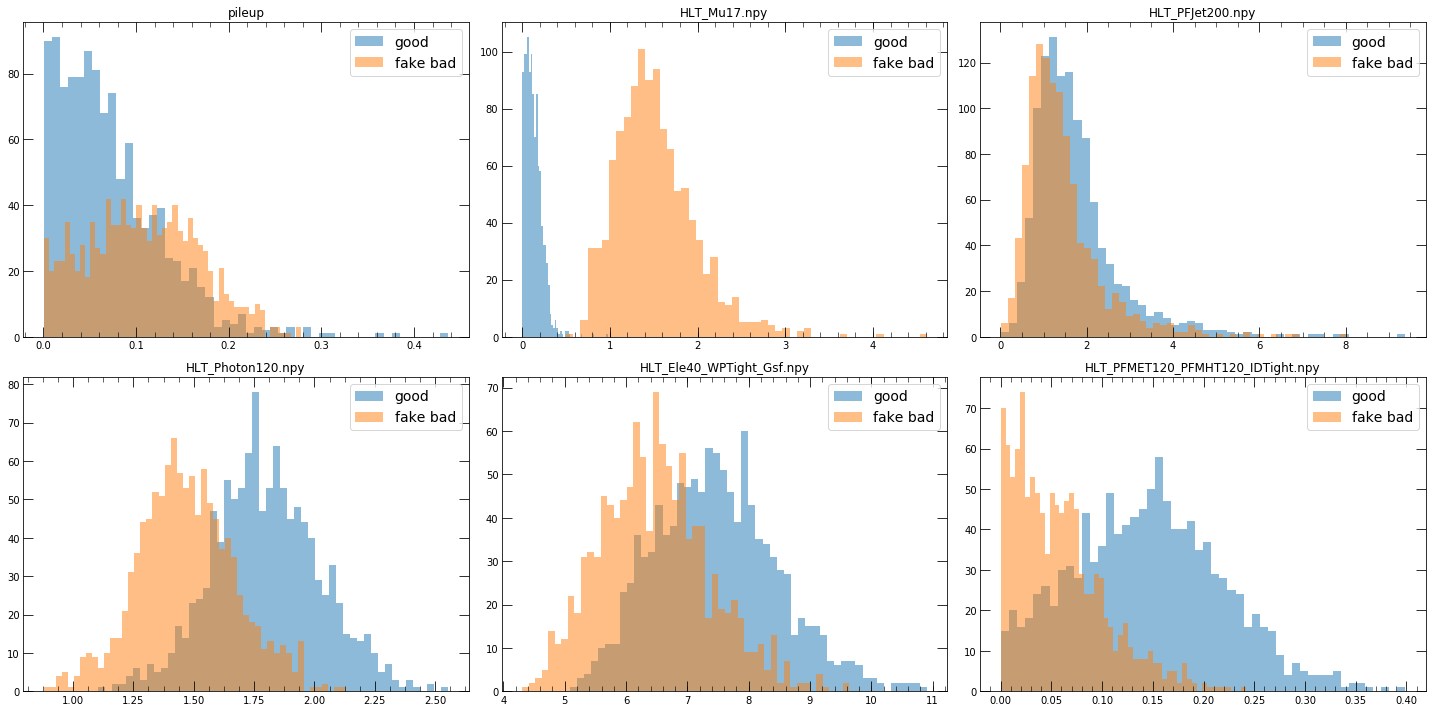

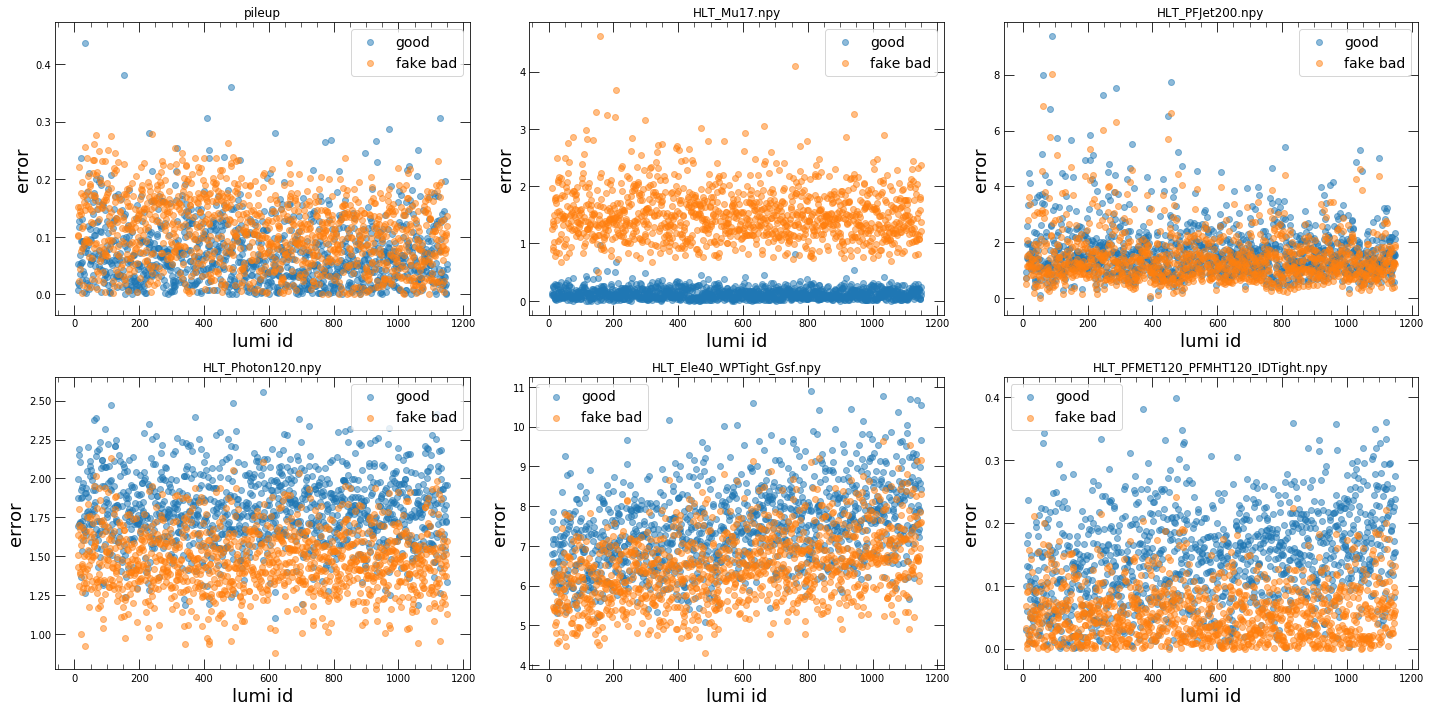

In [22]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi = data[str(runs[2])]['lumiid'] 
#print(len(error_reformat_bad[0]),len(error_reformat[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

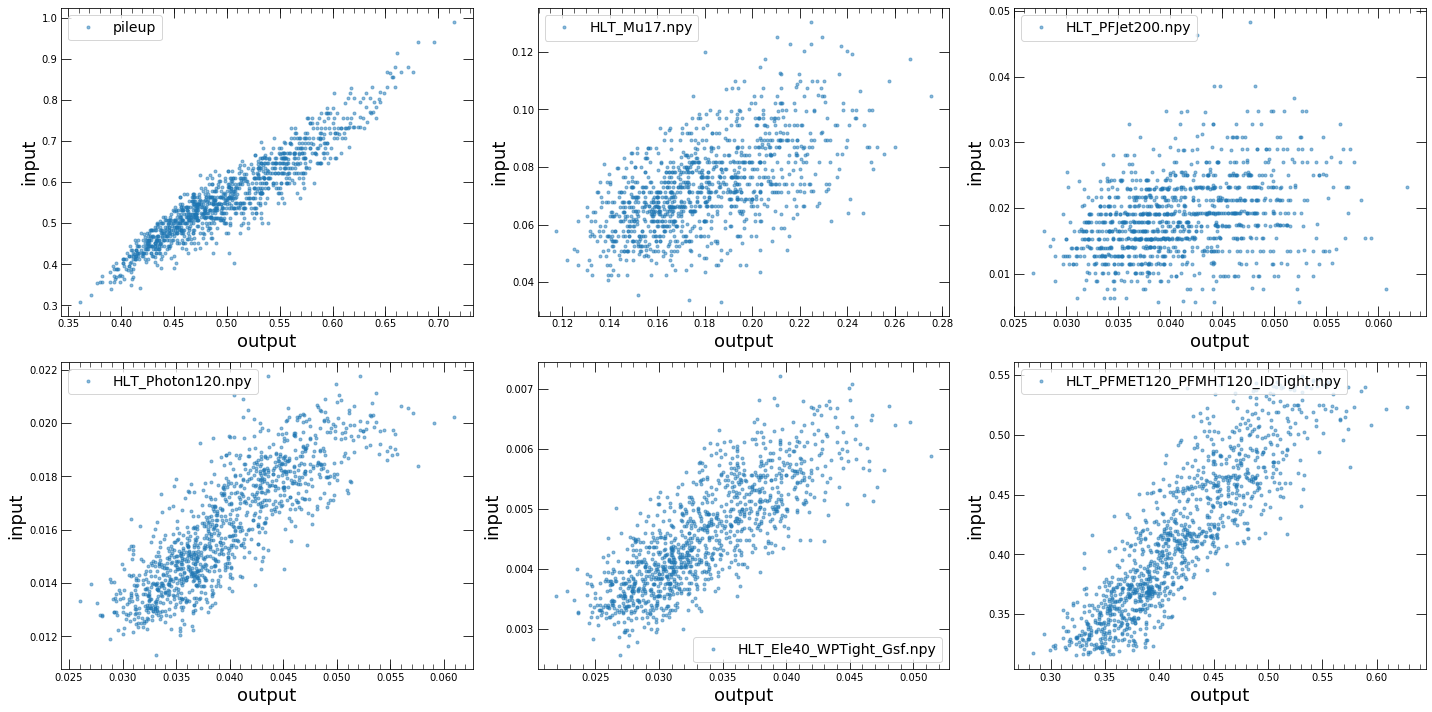

In [23]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()    
plt.tight_layout()
plt.show()

In [24]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [25]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[15,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,3,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[15,10])
# # for i in range(6):
# #     plt.subplot(2,3,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [26]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [27]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [28]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

1129 1129


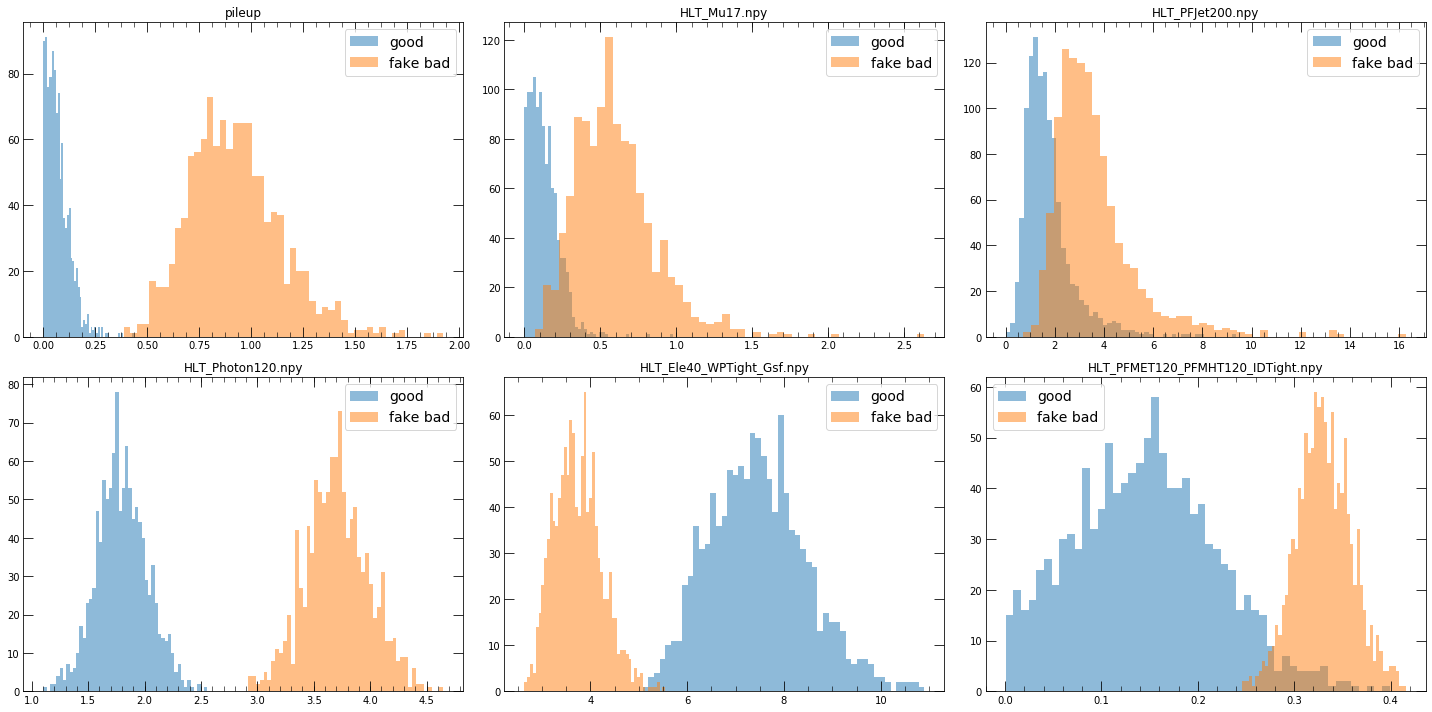

In [29]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
    
plt.show()

In [30]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.tight_layout()
    
plt.show()

In [31]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [32]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[15,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,3,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[15,10])
# # for i in range(6):
# #     plt.subplot(2,3,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [33]:
bad_runs = [301480]

with open('normedRateAvg_bad.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [34]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        lumi_new.append(lumiBad[l])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [35]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

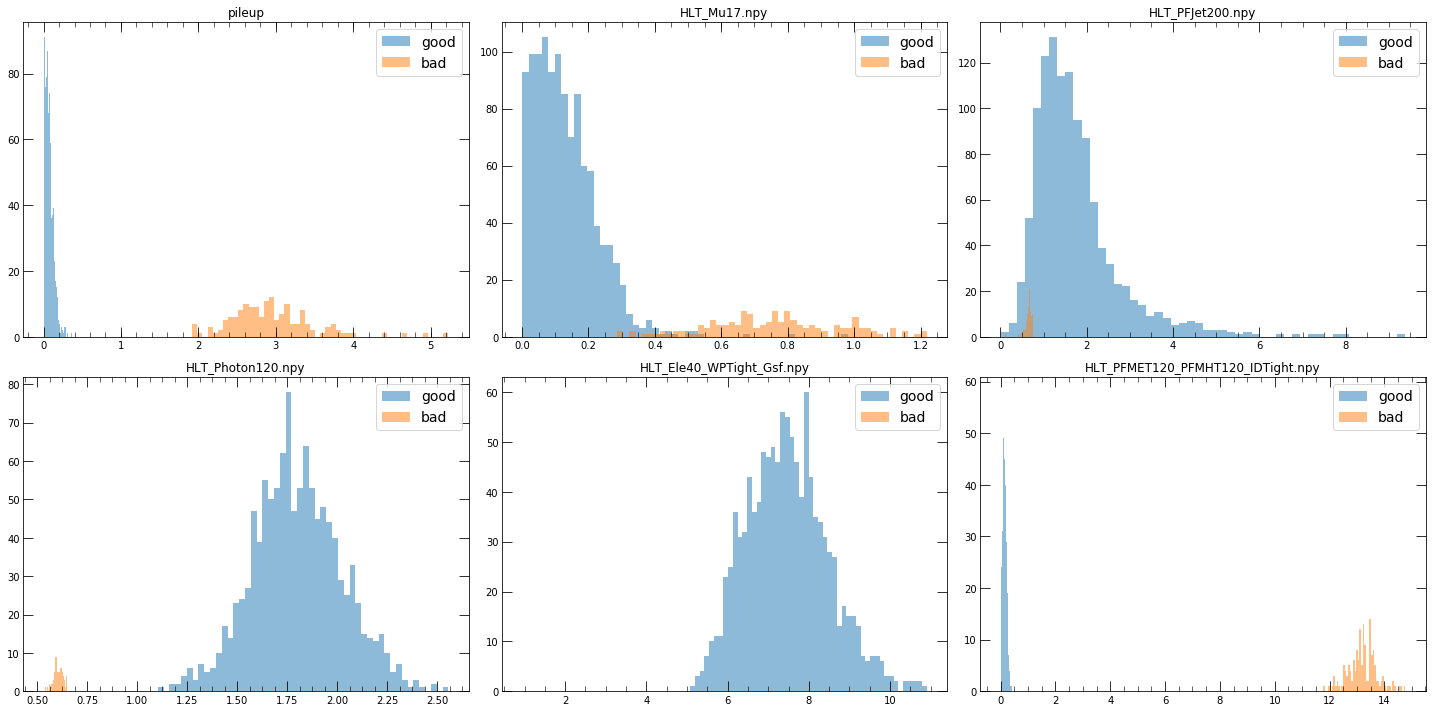

In [36]:
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
#print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

In [37]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()   

plt.tight_layout()
plt.show()

## Real Bad Data

In [38]:
bad_runs = [305588]
x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [39]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        lumi_new.append(lumiBad[l])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [40]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

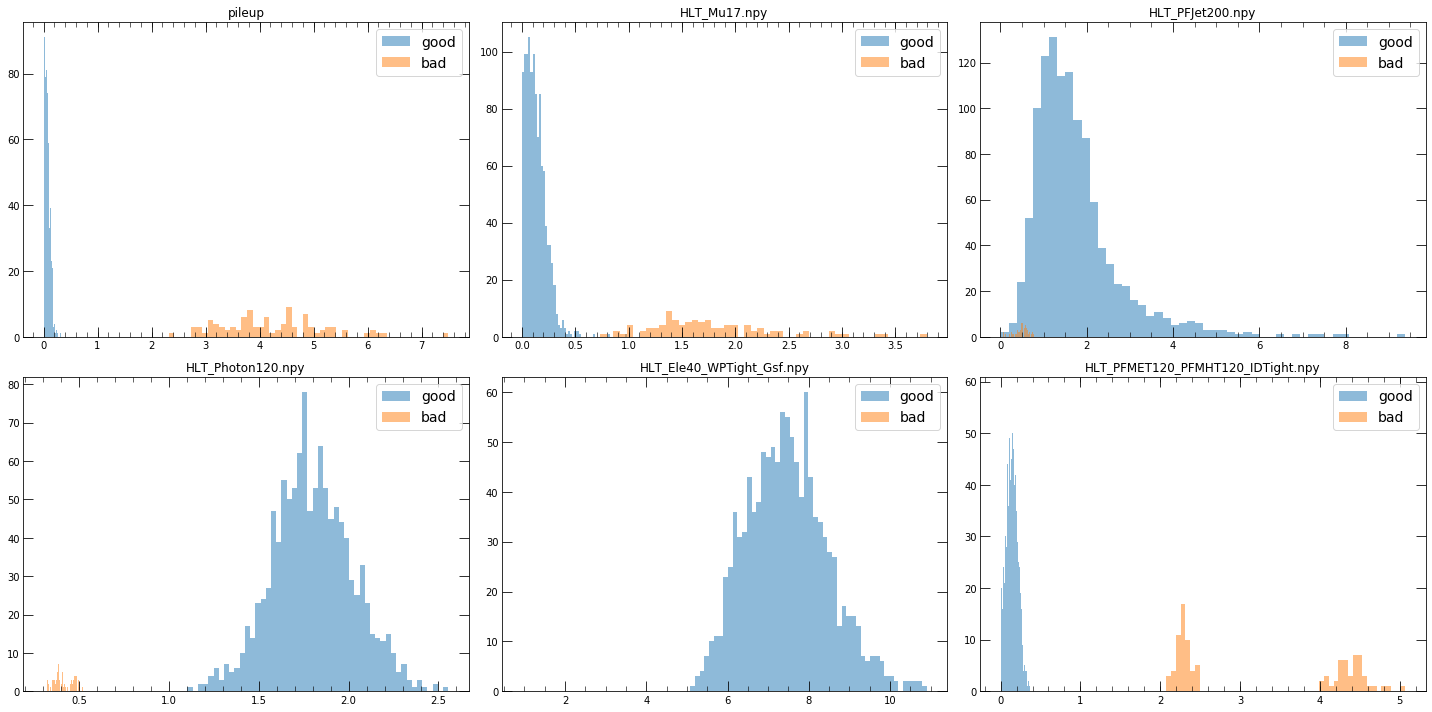

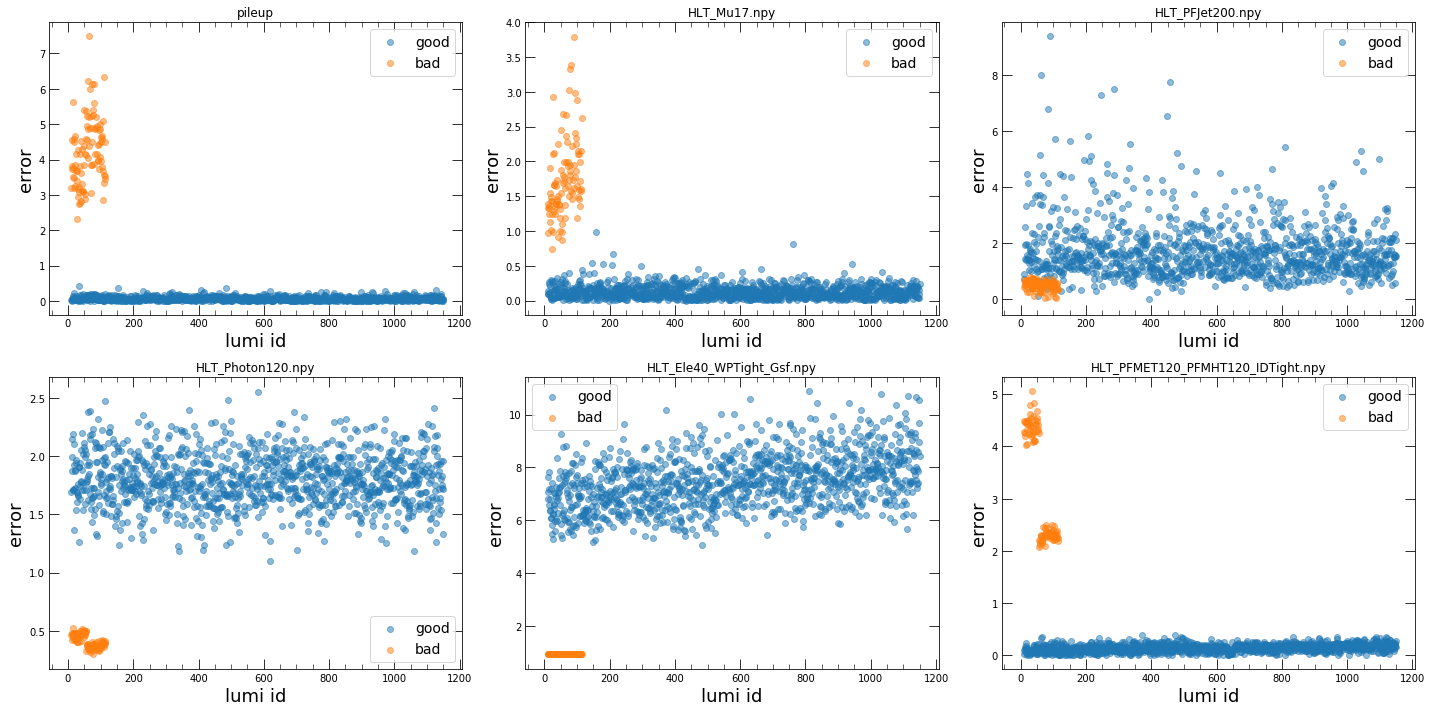

In [41]:
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()
plt.show()

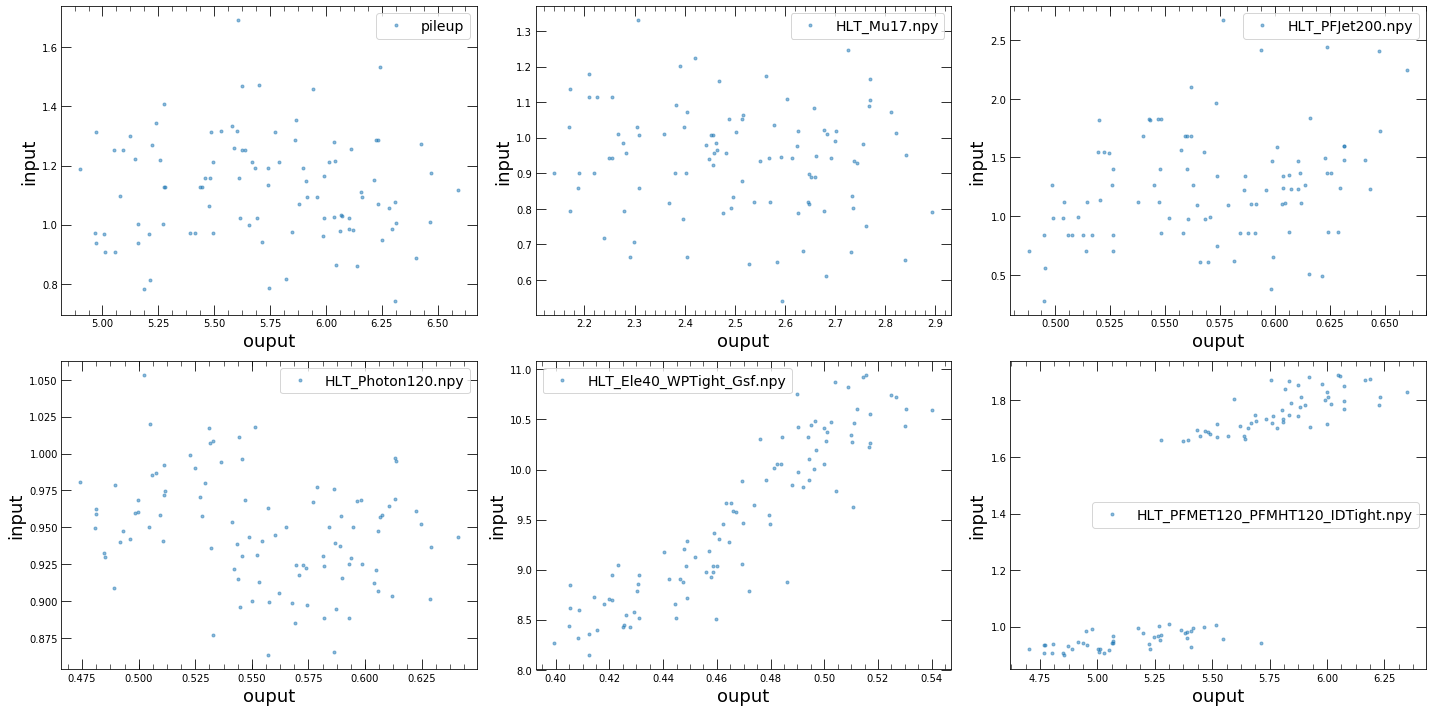

In [42]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('ouput')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    
plt.tight_layout()
plt.show()